# 多层全连接神经网络

## 1 线性模型

### 1.1 一维线性回归

In [1]:
import torch
import numpy as np
from torch import nn, optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()                  # gpu可用
device = torch.device('cuda' if use_cuda else 'cpu')  # 优先使用gpu

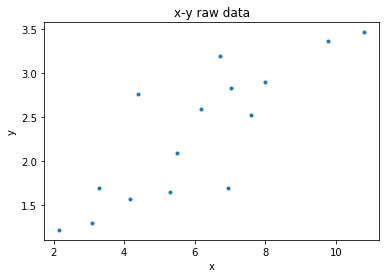

In [2]:
# 1.创建数据
x_train = np.array([3.3, 4.4, 5.5, 6.71, 6.93, 4.168, 9.779, 6.182, 7.59,
                    2.167, 7.042, 10.791, 5.313, 7.997, 3.1], dtype=np.float32)
y_train = np.array([1.7, 2.76, 2.09, 3.19, 1.694, 1.573, 3.366, 2.596, 2.53, 1.221,
                   2.827, 3.465, 1.65, 2.904, 1.3], dtype=np.float32)
x_train = np.reshape(x_train, [-1, 1])  # 转换为列向量
y_train = np.reshape(y_train, [-1, 1])
plt.plot(x_train, y_train, '.')
plt.title('x-y raw data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
# 将numpy的数据转换为torch的tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_train.shape

torch.Size([15, 1])

In [4]:
# 2.构建一维线性回归模型，即 y = w*x + b
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()              # python3中继承类的初始化方法
        self.linear = nn.Linear(1, 1)   # 定义一维的输入和输出
    def forward(self, x):               # 模型的前向传播
        output = self.linear(x)         # 计算output=w*x+b
        return output

In [5]:
# 3.实例化一个模型，并定义损失函数和优化函数
# if torch.cuda.is_available():
#     model = LinearRegression().cuda()   # 将模型放到GPU上执行
# else:
#     model = LinearRegression()
model = LinearRegression().to(device)     # 如果GPU可用则优先选择
print('1.一维线性回归模型:\n',model)
criterion = nn.MSELoss()                             # 使用均方误差损失
optimizer = optim.SGD(model.parameters(), lr=1e-3)   # 使用SGD优化方法

1.一维线性回归模型:
 LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [6]:
# 4.开始训练模型
num_epochs = 300
# 先将训练数据变为Variable,x_train包含所有的数据
# inputs, target = (Variable(x_train).cuda(), Variable(y_train).cuda()) \
#                 if torch.cuda.is_available() \
#                 else (Variable(x_train), Variable(y_train))
inputs, target = x_train.to(device), y_train.to(device)
for epoch in range(num_epochs):
    # forward
    out = model(inputs)                # 先进行前向传播
    loss = criterion(out, target)      # 计算损失函数
    # backward
    optimizer.zero_grad()              # 每次反向传播先归零梯度
    loss.backward()                    # 反向传播
    optimizer.step()                   # 更新参数
    # validate
    if (epoch + 1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'.format(epoch+1, num_epochs, loss.data.item()))

Epoch[20/300], loss: 1.671448
Epoch[40/300], loss: 0.211000
Epoch[60/300], loss: 0.171646
Epoch[80/300], loss: 0.170569
Epoch[100/300], loss: 0.170524
Epoch[120/300], loss: 0.170507
Epoch[140/300], loss: 0.170491
Epoch[160/300], loss: 0.170475
Epoch[180/300], loss: 0.170459
Epoch[200/300], loss: 0.170443
Epoch[220/300], loss: 0.170427
Epoch[240/300], loss: 0.170412
Epoch[260/300], loss: 0.170397
Epoch[280/300], loss: 0.170381
Epoch[300/300], loss: 0.170366


torch.FloatTensor


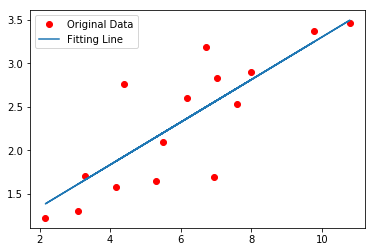

In [7]:
# 5.评估模型性能
# %pylab    
model.eval()                     # 模型变成测试模式
model.cpu()                      # 将模型和测试数据都放到cpu上
inputs = inputs.cpu()           
# inputs = inputs.to(torch.device('cpu'))
print(inputs.type())
predict = model(inputs)          # 对输入数据的输出进行预测
predict = predict.data.numpy()   # 转换为numpy数据才可以画图
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
# 是一条直线，所以顺序不会影响绘图
plt.plot(x_train.numpy(), predict, label='Fitting Line')  
plt.legend(['Original Data', 'Fitting Line'])
plt.show()

小结:
1. 创建数据或数据的读取及预处理
2. 构建网络模型
3. 实例化模型并定义损失函数及优化方法
4. 读入数据训练网络，同时输出准确率的验证结果
5. 测试模型的性能并可视化

### 1.2 多项式回归
每一维特征属性的次数不唯一

In [8]:
# 1.数据的创建和预处理
def make_features(x):
    """使数据X处理为多项式矩阵[x, x^2, x^3]"""
    x =x.unsqueeze(1)            # 参数1变为列向量，参数0变为行向量
    # 拼接的是tensor组成的列表，1表示按列拼接，0表示按行拼接 (0行1列)
    return torch.cat([x**i for i in range(1,4)], 1)   # 按列拼接为矩阵
# 使数据满足y=0.9+0.5*x+3*x^2+2.4*x^3关系，向量化为y = X*W + b
w_target = torch.Tensor([0.5, 3, 2.4]).unsqueeze(1)   # 权重变为列向量
b_target = torch.Tensor([0.9])
def func(x):    # 构建函数关系式
    return x.mm(w_target) + b_target    # y = X*W + b，得到列向量

test = torch.Tensor([1,2,3,4,5,6,7])
test_out = make_features(test)
print('1.拼接后的矩阵:\n', test_out)
out = func(test_out)
print('2.满足多项式的输出:\n', out)

1.拼接后的矩阵:
 tensor([[  1.,   1.,   1.],
        [  2.,   4.,   8.],
        [  3.,   9.,  27.],
        [  4.,  16.,  64.],
        [  5.,  25., 125.],
        [  6.,  36., 216.],
        [  7.,  49., 343.]])
2.满足多项式的输出:
 tensor([[  6.8000],
        [ 33.1000],
        [ 94.2000],
        [204.5000],
        [378.4000],
        [630.3000],
        [974.6000]])


In [9]:
# 上述函数合并为一个process_data
def process_data(input_x):           # 预处理数据
    input_x = input_x.unsqueeze(1)   # 得到列向量
    concat_x = torch.cat([input_x**i for i in range(1,4)], 1)  # 按列拼接为矩阵
    w_target = torch.Tensor([0.5, 3, 2.4]).unsqueeze(1)        # 权重变为列向量
    b_target = torch.Tensor([0.9])
    output_y = concat_x.mm(w_target) + b_target                # 使数据符合多项式
    return concat_x, output_y
# test = torch.Tensor([1,2,3,4,5,6,7])
# x, y = process_data(test)
def get_batch(batch_size=32):      # 返回batch_size的(x,y)数据对用于训练
    random_data = torch.randn(batch_size)            # 随机产生高斯分布的数据
    x_train, y_train = process_data(random_data)     # 产生符合要求的数据
#     inputs, target = (Variable(x_train).cuda(), Variable(y_train).cuda()) \
#                 if torch.cuda.is_available() \
#                 else (Variable(x_train), Variable(y_train))
    inputs, target = x_train.to(device), y_train.to(device)
    return inputs, target

In [10]:
# 2.构建模型并定义损失函数及优化方法
# 定义模型
class poly_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.poly = nn.Linear(3,1)   # y = X*W + b, x为3维，y为1维
    def forward(self, x):
        return self.poly(x)
# model = poly_model().cuda() if torch.cuda.is_available() else poly_model()
model = poly_model().to(device)
# 定义损失函数与优化方法
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [11]:
# 3.训练模型
num_batches = 0       # ！！！注意这里的batch数据迭代的次数，不是epoch 
while True:
    batch_x, batch_y = get_batch()       # 获取数据
    output = model(batch_x)              # 前向传播
    loss = criterion(output, batch_y)    # 计算损失函数
    print_loss = loss.data.item()
    optimizer.zero_grad()                # 梯度归零
    loss.backward()                      # 误差反向传播
    optimizer.step()                     # 更新参数
    num_batches += 1        
    if print_loss < 1e-3:
        break
    if num_batches % 100 == 0:
        print('Num_batches[{}], loss: {:.6f}'.format(num_batches+1, print_loss))

Num_batches[101], loss: 11.906305
Num_batches[201], loss: 1.280829
Num_batches[301], loss: 0.346025
Num_batches[401], loss: 0.077029
Num_batches[501], loss: 0.137702
Num_batches[601], loss: 0.021907
Num_batches[701], loss: 0.019165
Num_batches[801], loss: 0.013940
Num_batches[901], loss: 0.014522
Num_batches[1001], loss: 0.027717
Num_batches[1101], loss: 0.010648
Num_batches[1201], loss: 0.007721
Num_batches[1301], loss: 0.006071
Num_batches[1401], loss: 0.005099
Num_batches[1501], loss: 0.004672
Num_batches[1601], loss: 0.004756
Num_batches[1701], loss: 0.003049
Num_batches[1801], loss: 0.001870
Num_batches[1901], loss: 0.002457
Num_batches[2001], loss: 0.001583


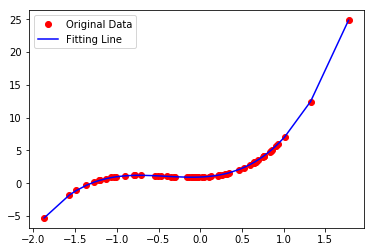

In [12]:
# 4.评估模型性能
# %pylab    
model.eval()                     # 模型变成测试模式
model.cpu()
test_x, test_y = get_batch(64)
test_x, test_y = test_x.cpu(), test_y.cpu()  # 将数据放到cpu上
predict = model(test_x)          # 对输入数据的输出进行预测
predict = predict.data.numpy()   # 转换为numpy数据才可以画图
test_x = test_x[:,0].unsqueeze(1)
plt.plot(test_x.numpy(), test_y.numpy(), 'ro', label='Original Data')
# 由于数据大小顺序是乱的，故无法画出曲线？？？
# plt.plot(test_x.numpy(), predict, 'b.',label='Fitting Data')
plt_data = np.concatenate((test_x.numpy(), predict), axis=1)
# 将数据按第一行排序后绘制直线
plt_data = plt_data[plt_data[:,0].argsort()]
plt.plot(plt_data[:,0], plt_data[:,1], 'b-', label='Fitting Line')
plt.legend()
plt.show()

## 2 分类问题

### 2.1 Logistic回归
Logistic回归中，输出y=1的对数概率是x的线性函数：

1. 拟合决策边界(线性或多项式都行)
2. 建立决策边界和分类概率的关系，得到分类概率

In [13]:
import torch
import numpy as np
from torch import nn, optim
# %pylab inline
import matplotlib.pyplot as plt
from torch.autograd import Variable

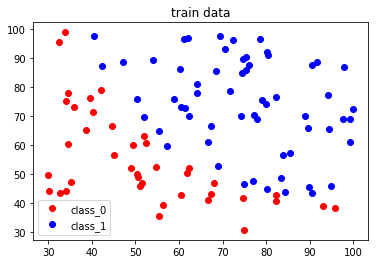

In [14]:
# 1.读取数据
def get_data(file_name):
    with open(file_name) as file:
        data_list = file.read().split('\n')     # 使用readlines会包含回车符
        # 使用map函数将子列表的每个元素转换为float
        data_list = [list(map(float, row.split(','))) for row in data_list]
        # 使用filter函数过滤数据，两类数据分开
        label0 = np.array(list(filter(lambda x: x[-1]==0, data_list)))
        label1 = np.array(list(filter(lambda x: x[-1]==1, data_list)))
    x0, y0 = label0[:, 0], label0[:, 1]
    x1, y1 = label1[:, 0], label1[:, 1]
    plt.plot(x0, y0, 'ro', label='class_0')
    plt.plot(x1, y1, 'bo', label='class_1')
    plt.legend(loc='best')
    plt.title('train data')
    plt.show()
    
    x_train = np.concatenate((label0[:,:2], label1[:, :2]), axis=0)  # 按行拼接
    y_train = np.array([0]*label0.shape[0] + [1]*label1.shape[0])    # 构建label
    data_train = np.concatenate((x_train, y_train[:,np.newaxis]), axis=1)
#     print(data_train)
    return data_train        # 返回 numpy格式的训练数据
mydata = get_data('data.txt')

In [15]:
# 产生训练模型的batch数据
import random
def get_batch(data, batch_size=100):                     # 生成数据的迭代器
    """data:特征+标签的numpy数据
       batch_size:批次的大小
       返回批次训练数据的生成器"""
    train_data = data
    order = list(range(len(train_data)))
    random.shuffle(order)               # shuffle作用于多维数组会出现重复的行！！！
    train_data = train_data[order]
    index = 0
#     print(type(data))
    while True:
        if index + batch_size < len(train_data):
            total_data = train_data[index: index+batch_size] # 按照行访问数据
            index += batch_size
        else:
            total_data = train_data[index:] 
            index = 0 
            order = list(range(len(train_data)))  # 再次打乱顺序
            random.shuffle(order)                 # shuffle作用于多维数组会出现重复的行！！！
            train_data = train_data[order]
        yield total_data[:, :2], total_data[:, -1:]
g = get_batch(mydata)

In [16]:
test_x, test_y = next(g)
# print(test_x)
print(test_x.shape)
print(test_y.shape)

(100, 2)
(100, 1)


In [17]:
# 2.定义模型、损失函数及优化方法
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)   # 模型两个特征，一个输出
        self.sigm   = nn.Sigmoid()
    def forward(self, x):
        x = self.linear(x)
#         print('x:', x)
        out = self.sigm(x)
        return out
# logistic_model = LogisticRegression().cuda() if torch.cuda.is_available() \
#                  else LogisticRegression()
logistic_model = LogisticRegression().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(logistic_model.parameters(), lr=1e-3, momentum=0.9)

**BCELoss()**

定义: $loss(o,t)=-\frac{1}{n}\sum_i{(t_i \cdot log(o_i)+(1-t_i) \cdot log(1-o_i))}$

In [18]:
# 3.训练网络
num_batches = 10000#10000                      # ！！！注意这里的batch数据迭代的次数，不是epochs 
gen = get_batch(mydata, batch_size=100)   # batch_size=100访问所有数据,num_batches等同于epochs
for epoch in range(num_batches):
    x, y = next(gen) 
    x, y = map(torch.Tensor, (x,y))       # 将x，y转换为张量   
    x_train, y_train = x.to(device), y.to(device)
#     x_train, y_train = (Variable(x).cuda(), Variable(y).cuda()) \
#                        if torch.cuda.is_available() \
#                        else (Variable(x), Variable(y))  # 转换为Variable

    # 前向传播
    out = logistic_model(x_train)         # 计算输出
    loss = criterion(out, y_train)        # 计算损失函数
    print_loss = loss.data                # 获取损失函数的值
#     print('=====', print_loss)
    mask = out.ge(0.5).float()            # 大于0.5的设置为1，否则设置为0
    correct = (mask == y_train).sum()     # 统计预测正确的个数，这里得到整型tensor
    # 必须转换为numpy运算才行
    
    acc = correct.data.float() / y_train.shape[0]   # 计算准确率size(0)
#     print(acc)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 输出验证的结果
    if (epoch + 1) % 1000 == 0:
        print('-'*10)
        print('epoch {}'.format(epoch+1))
        print('loss is {:.4f}'.format(print_loss))
        print('acc is {:.4f}'.format(acc))

----------
epoch 1000
loss is 0.5704
acc is 0.6300
----------
epoch 2000
loss is 0.5350
acc is 0.6600
----------
epoch 3000
loss is 0.5049
acc is 0.7000
----------
epoch 4000
loss is 0.4793
acc is 0.7700
----------
epoch 5000
loss is 0.4574
acc is 0.8100
----------
epoch 6000
loss is 0.4384
acc is 0.8300
----------
epoch 7000
loss is 0.4219
acc is 0.8600
----------
epoch 8000
loss is 0.4074
acc is 0.8900
----------
epoch 9000
loss is 0.3947
acc is 0.9000
----------
epoch 10000
loss is 0.3833
acc is 0.9100


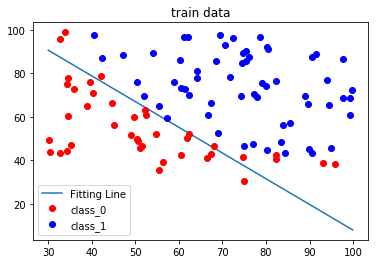

In [19]:
# 4.绘制拟合曲线,该部分总是出现划线偏的问题,数据集随机没有处理好
# %matplotlib inline
# mydata = get_data('data.txt')
logistic_model.cpu() 
w0, w1 = logistic_model.linear.weight[0]      # 模型得到的变量均为Variable类型
w0, w1 = w0.data.numpy(), w1.data.numpy()
b = logistic_model.linear.bias.data.numpy()
plot_x = np.arange(30, 100, 0.1)
plot_y = (-w0 * plot_x - b) / w1
plt.plot(plot_x, plot_y, label='Fitting Line')
mydata = get_data('data.txt')                # pyplot画的图可以直接叠加

小结:
- random.shuffle()处理一维的列表和numpy数组时只是打乱顺序，但在处理多维numpy数组时，该函数会将数组的行随机的重复，所以要格外注意
- 在PyTorch中，在计算数值时最好转换到相同的格式，如都是numpy格式或tensor格式，防止出错，cpu和gpu数据一定不要混用，训练时全放到GPU上，测试时可以使用cpu
- 在PyTorch中，注意IntTensor()数据运算的'/'符号被认为整除符号，转换为float型计算除法
- matplotlib绘制的图可以直接叠加，即使一部分图是在函数中绘制的

In [20]:
# numpy数组排序
a = np.array([[1,3,2,0,5],[2, 4,3,1,6], [0, 2, 1, -1, 4]])
data = np.array(a)
print('1.原数据:\n', data)
print('2.按第3列排序:\n', data[data[:,2].argsort()] )  # 按第3列排序
print('3.按第2行排序:\n', data[:,data[1].argsort()])   # 按第2行排列

1.原数据:
 [[ 1  3  2  0  5]
 [ 2  4  3  1  6]
 [ 0  2  1 -1  4]]
2.按第3列排序:
 [[ 0  2  1 -1  4]
 [ 1  3  2  0  5]
 [ 2  4  3  1  6]]
3.按第2行排序:
 [[ 0  1  2  3  5]
 [ 1  2  3  4  6]
 [-1  0  1  2  4]]


In [21]:
# 该方法可以将程序写到py脚本中！！！
# %%writefile script_name.py
# def hello():
#     pass

## 3 多层全连接前向网络

In [22]:
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [23]:
# 设置超参数(Hyperparameters)
batch_size = 64
learning_rate = 1e-2
num_epochs = 20

In [24]:
# 1.读取数据及预处理
# Compose将各种预处理操作组合，ToTensor将图片处理为tensor，
# Normalize(mean, variance)正则化
data_tf = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize([0.5], [0.5])])
# 下载MNIST手写数字训练集
train_dataset = datasets.MNIST(root='./data/MNIST', train=True, transform=data_tf, download=False)
test_dataset = datasets.MNIST(root='./data/MNIST', train=False, transform=data_tf)
# 创建数据迭代器便于训练模型
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
print('1.训练数据的维度:')
print(train_dataset.train_data.shape)
print(train_dataset.train_labels.shape)
print('2.测试数据的维度:')
print(test_dataset.test_data.shape)
print(test_dataset.test_labels.shape)

1.训练数据的维度:
torch.Size([60000, 28, 28])
torch.Size([60000])
2.测试数据的维度:
torch.Size([10000, 28, 28])
torch.Size([10000])


(array([   2,    5,   14, ..., 9978, 9984, 9994], dtype=int64),)
1.0~9样本的索引: [10, 5, 35, 30, 6, 15, 21, 17, 84, 9]
2.手写体样本:


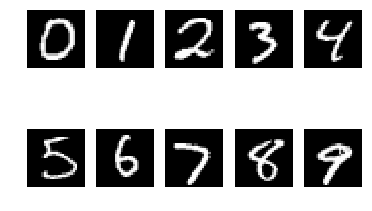

In [26]:
# 显示数据
%matplotlib inline
test = test_dataset.test_labels.numpy()     # 将tensor数据转换为numpy数据
print(np.where(test==1))
sample_index = [np.where(test==i)[0][1] for i in range(10)] # np.where的输出(array([], dtype),)
print('1.0~9样本的索引:', sample_index)
sample_data = test_dataset.test_data[sample_index]    # 获取10个样本数据
print('2.手写体样本:')
for i in range(10):
    plt.subplot(2,5,i+1)
    sample_data = test_dataset.test_data[sample_index][i]
    plt.axis("off")       # 关掉坐标轴
    plt.imshow(sample_data, interpolation='none', cmap='gray')

In [27]:
# 2.定义模型
# (1)定义简单的模型
class Simple_Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super().__init__() 
        self.layer1 = nn.Linear(in_dim, n_hidden_1)      # 定义结构
        self.layer2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.layer3 = nn.Linear(n_hidden_2, out_dim)
    def forward(self, x):    # 前向传播
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
# (2)定义含激活函数的模型
class Activation_Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super().__init__()    # 定义结构
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),
                                    nn.ReLU(True))  
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),
                                    nn.ReLU(True))
        self.layer3 = nn.Linear(n_hidden_2, out_dim)
    def forward(self, x):    # 前向传播
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
# (3)定义含批标准化的模型
class Batch_Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super().__init__()    # 定义结构
        # Sequential组合网络的层
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),
                                    nn.BatchNorm1d(n_hidden_1), nn.ReLU(True))  
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),
                                    nn.BatchNorm1d(n_hidden_2), nn.ReLU(True))
        self.layer3 = nn.Linear(n_hidden_2, out_dim)
    def forward(self, x):    # 前向传播
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [28]:
# 3.定义损失函数及优化方法
# model = Simple_Net(784, 300, 100, 10)    # Activation_Net, Batch_Net
# model = Activation_Net(784, 300, 100, 10) 
model = Batch_Net(784, 300, 100, 10) 
# if torch.cuda.is_available():
#     model = model.cuda()
model.to(device)
criterion = nn.CrossEntropyLoss()       # 使用交叉熵损失函数
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [29]:
%%time
# 4.训练模型
# 批次数据x:[64, 1, 28, 28], y:[64]
epochs = 10
for epoch in range(epochs):
    print('-'*50)
    print('Epoch {}'.format(epoch))
    for num_batches, data in enumerate(train_loader):   # 访问一个完整的epoch
        x_train, y_train = data               # 获取训练批次数据
        x_train, y_train = x_train.to(device), y_train.to(device)
#         print(x_train.device)
#         print(x_train.shape, y_train.shape)
        # 前向传播
        # 注意：该处数据的维度应为[-1, input_dim]，第一个维度前面都是batch_size，
        # 但数据集尾部会出现不足batch_size的部分，-1更合理，第2个维度是固定的
        x_train = x_train.reshape([-1, 28*28]) # 使维度变为[-1, 28*28]
#         print(x_train.shape)
        out = model(x_train)                  # 计算模型输出 [64,10]
#         print(out.shape)
#         print(y_train.shape, y_train)
        
        loss = criterion(out, y_train)        # 计算损失函数
        print_loss = loss.data
        # 反向传播
        optimizer.zero_grad()        # 梯度归零
        loss.backward()              # 梯度方向传播
        optimizer.step()             # 更新参数
        if (num_batches + 1) % 450 == 0:
            print('Num batches {}'.format(num_batches + 1))
            print('loss {:.4f}'.format(print_loss))

--------------------------------------------------
Epoch 0
Num batches 450
loss 0.5349
Num batches 900
loss 0.3815
--------------------------------------------------
Epoch 1
Num batches 450
loss 0.2376
Num batches 900
loss 0.1064
--------------------------------------------------
Epoch 2
Num batches 450
loss 0.1314
Num batches 900
loss 0.1567
--------------------------------------------------
Epoch 3
Num batches 450
loss 0.0243
Num batches 900
loss 0.1633
--------------------------------------------------
Epoch 4
Num batches 450
loss 0.0927
Num batches 900
loss 0.0463
--------------------------------------------------
Epoch 5
Num batches 450
loss 0.0887
Num batches 900
loss 0.0996
--------------------------------------------------
Epoch 6
Num batches 450
loss 0.1338
Num batches 900
loss 0.0303
--------------------------------------------------
Epoch 7
Num batches 450
loss 0.0633
Num batches 900
loss 0.0630
--------------------------------------------------
Epoch 8
Num batches 450
loss 

In [30]:
%%time
# 5.评价模型的性能
model.eval()                                      # 将模型转换为测试状态
total_loss = 0
total_acc = 0
test_epoch = 0 

for data in test_loader:
    eval_loss = 0
    eval_acc = 0
    img, label = data                                      # 获取测试数据
#     print(img.shape)
    img = img.view(img.size(0), -1)                        # 返回一个数据相同但维度不同的tensor
    # 由于测试状态下不需方向传播，所以可以释放缓存
    with torch.no_grad():
        img, label = img.to(device), label.to(device)
#         img, label = (Variable(img).cuda(), Variable(label).cuda()) \
#                      if torch.cuda.is_available() \
#                      else (Variable(img), Variable(label))
        out = model(img)     # 计算图像的标签 [img.size(0), 10]
        loss = criterion(out, label)
        eval_loss += loss.data* label.size(0)              # 计算该批次的总损失
        _, pred = torch.max(out, 1)                        # 在一行内按列比大小得[64,1],tenso为[64]
    #     print(_, pred.shape)
        num_correct = (pred == label).sum()
        eval_acc += num_correct.data
    #     print(eval_acc)    
        total_loss += eval_loss                            # 累计所有批次数据的损失和准确率
        total_acc  += eval_acc
        if (test_epoch + 1) % 2 == 0:
            batch_loss  = (eval_loss / img.size(0))        # 计算该批次的损失
            batch_acc   = (eval_acc.float() / img.size(0)) # 计算该批次的准确率
            print('Epoch: {} Test Loss: {:.6f}, ACC: {:.6f}'.format(test_epoch+1, batch_loss, batch_acc))
        test_epoch += 1
print('----------Test Done!----------')
print('Epoch: {} Total_Loss: {:.6f} Total_ACC: {:.6f}'.format(\
      test_epoch, total_loss/len(test_dataset), total_acc.float()/len(test_dataset)))

Epoch: 2 Test Loss: 0.020145, ACC: 1.000000
Epoch: 4 Test Loss: 0.115917, ACC: 0.984375
Epoch: 6 Test Loss: 0.082434, ACC: 0.984375
Epoch: 8 Test Loss: 0.047114, ACC: 0.984375
Epoch: 10 Test Loss: 0.124163, ACC: 0.953125
Epoch: 12 Test Loss: 0.041718, ACC: 0.984375
Epoch: 14 Test Loss: 0.046981, ACC: 1.000000
Epoch: 16 Test Loss: 0.127097, ACC: 0.968750
Epoch: 18 Test Loss: 0.088028, ACC: 0.968750
Epoch: 20 Test Loss: 0.353063, ACC: 0.921875
Epoch: 22 Test Loss: 0.060695, ACC: 0.984375
Epoch: 24 Test Loss: 0.177051, ACC: 0.937500
Epoch: 26 Test Loss: 0.066317, ACC: 0.968750
Epoch: 28 Test Loss: 0.112695, ACC: 0.968750
Epoch: 30 Test Loss: 0.125585, ACC: 0.953125
Epoch: 32 Test Loss: 0.256382, ACC: 0.921875
Epoch: 34 Test Loss: 0.126841, ACC: 0.953125
Epoch: 36 Test Loss: 0.049064, ACC: 0.984375
Epoch: 38 Test Loss: 0.152388, ACC: 0.937500
Epoch: 40 Test Loss: 0.038084, ACC: 1.000000
Epoch: 42 Test Loss: 0.147117, ACC: 0.968750
Epoch: 44 Test Loss: 0.080607, ACC: 0.953125
Epoch: 46 Test

1.模型一

Epoch: 157 Total_Loss: 0.291483 Total_ACC: 0.919000


2.模型二

Epoch: 157 Total_Loss: 0.195421 Total_ACC: 0.944600

3.模型三

Epoch: 157 Total_Loss: 0.070033 Total_ACC: 0.979000